In [14]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM

base_model = ResNet50(weights='imagenet', include_top=False)


In [15]:
x = base_model.output


x = GlobalAveragePooling2D()(x)

# x = LSTM(64)(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(117, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# Should add metric=[...]
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_dir = r'..\Data\labledCountries\train'
validation_data_dir = r'..\Data\labledCountries\val'

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [17]:

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    # shuffle=True
    )

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical')


Found 133426 images belonging to 117 classes.
Found 29568 images belonging to 117 classes.


In [18]:
import numpy as np

class_counts = np.bincount(train_generator.classes) ** 0.3

# class_probabilities = class_counts
class_probabilities = 1 / np.bincount(train_generator.classes)
class_probabilities = np.where(np.isinf(class_probabilities) | np.isnan(class_probabilities), 0, class_probabilities)
# class_probabilities[44] = 0
class_probabilities = class_probabilities / np.sum(class_probabilities)
class_weights = {i: weight for i, weight in enumerate(class_probabilities)}

class_indices = train_generator.class_indices

class_probabilities_dict = {class_name: class_probabilities[idx] for class_name, idx in class_indices.items()}

sorted_class_probabilities = sorted(class_probabilities_dict.items(), key=lambda item: item[1], reverse=False)

for class_name, probability in sorted_class_probabilities:
    print(f'{class_name}: {probability}')


Andorra: 0.0
Gibraltar: 0.0
Macao: 0.0
United States of America: 1.5456676052753386e-06
France: 6.975781546283477e-06
India: 8.4669242742933e-06
Russian Federation: 8.505253492375207e-06
Brazil: 9.914567263671151e-06
Canada: 9.965402208976396e-06
Australia: 1.2245125981744622e-05
Italy: 1.4801553280979647e-05
Japan: 1.4994497178497073e-05
Spain: 1.5488957101942976e-05
Thailand: 1.5792747238433877e-05
U.K. of Great Britain and Northern Ireland: 1.6058209371501566e-05
Poland: 1.7669064230084796e-05
Sweden: 2.0115744073508387e-05
Mexico: 2.1366305873377745e-05
Indonesia: 2.1753884559618102e-05
Norway: 3.182626476226454e-05
Argentina: 3.300018436415134e-05
Finland: 3.558353213003188e-05
South Africa: 4.075510838320354e-05
Turkey: 4.250702480691591e-05
Ireland: 4.5236207780072626e-05
Philippines: 4.7364970499134875e-05
Romania: 5.001270176927285e-05
Czech Republic: 5.531336103431844e-05
New Zealand: 5.828781271351655e-05
Portugal: 6.815515706646976e-05
Denmark: 6.865324591226613e-05
Greece:

C:\Users\21thebes\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=4,
    validation_data=validation_generator,
    validation_steps=30,
    class_weight = class_weights,
    verbose=1
    )


Epoch 1/4
200/200 [==============================] - 567s 3s/step - loss: 2.3367e-04 - categorical_accuracy: 0.0185 - val_loss: 4.7094 - val_categorical_accuracy: 0.0073
Epoch 2/4
200/200 [==============================] - 630s 3s/step - loss: 2.2814e-04 - categorical_accuracy: 0.0127 - val_loss: 4.7445 - val_categorical_accuracy: 0.0047
Epoch 3/4
200/200 [==============================] - 618s 3s/step - loss: 2.2303e-04 - categorical_accuracy: 0.0053 - val_loss: 4.7485 - val_categorical_accuracy: 0.0057
Epoch 4/4
200/200 [==============================] - 614s 3s/step - loss: 2.3281e-04 - categorical_accuracy: 0.0067 - val_loss: 4.7490 - val_categorical_accuracy: 0.0016


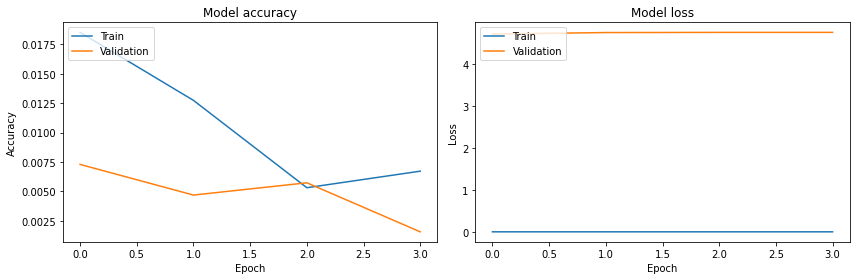

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])  
plt.plot(history.history['val_categorical_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [21]:
model.save('my_model.h5')


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

data_dir = r'..\Data\labledCountries\val'
generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

class_names = generator.class_indices.keys()
#print(class_names)

Found 29568 images belonging to 117 classes.


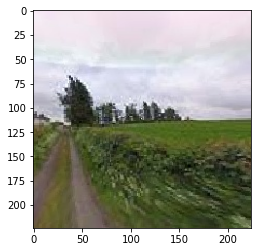

Country: ['United Arab Emirates'], Probability: 0.009348277933895588
Country: ['Bhutan'], Probability: 0.009263958781957626
Country: ['Guatemala'], Probability: 0.009257730096578598
Country: ['Mongolia'], Probability: 0.009210515767335892
Country: ['Jordan'], Probability: 0.009201042354106903
Country: ['New Zealand'], Probability: 0.009192169643938541
Country: ['Azores Islands'], Probability: 0.00917474739253521
Country: ['Faroe Islands'], Probability: 0.00915389135479927
Country: ['Svalbard and Jan Mayen Islands'], Probability: 0.009140974842011929
Country: ['The former Yugoslav Republic of Macedonia'], Probability: 0.009139389730989933
Country: ['Kenya'], Probability: 0.009127619676291943
Country: ['Kyrgyzstan'], Probability: 0.009122407995164394
Country: ['Israel'], Probability: 0.0091215455904603
Country: ['Bolivia'], Probability: 0.009106629528105259
Country: ['Uruguay'], Probability: 0.009074533358216286
Country: ['Swaziland'], Probability: 0.009016655385494232
Country: ['Bulgari

In [23]:
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load image
img_path = r'..\Data\labledCountries\test\Ireland\-k1VSj7m5z79IEH3idNLyA.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Display the image
plt.imshow(img)
plt.show()

# Preprocess image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255.0

# Make prediction
predictions = model.predict(x)

# Print predictions in sorted order
label_encoder = LabelEncoder()
label_encoder.fit(list(class_names))

for i in np.argsort(predictions[0])[::-1]:
    print(f'Country: {label_encoder.inverse_transform([i])}, Probability: {predictions[0][i]}')


In [24]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



1.15.8
GPU found
